# Qiskit Gradient Framework

The gradient framework enables the evaluation of quantum gradients as well as functions thereof.
Besides standard first order gradients of expectation values of the form
$$ \langle\psi\left(\theta\right)|\hat{O}\left(\omega\right)|\psi\left(\theta\right)\rangle $$
<!--- $$ \frac{\partial\langle\psi\left(\theta\right)|\hat{O}\left(\omega\right)|\psi\left(\theta\right)\rangle}{\partial\theta} $$

$$ \frac{\partial^2\langle\psi\left(\theta\right)|\hat{O}\left(\omega\right)|\psi\left(\theta\right)\rangle}{\partial\theta^2}, $$
--->

The gradient framework also supports the evaluation of second order gradients (Hessians), and the Quantum Fisher Information (QFI) of quantum states $|\psi\left(\theta\right)\rangle$.

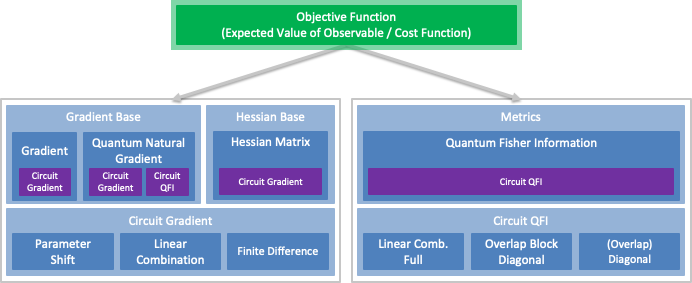

## Imports

In [1]:
#General imports
import numpy as np

#Operator Imports
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian

#Circuit imports
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.library import EfficientSU2

## First Order Gradients


Given a parameterized quantum state $|\psi\left(\theta\right)\rangle = V\left(\theta\right)|\psi\rangle$ with input state $|\psi\rangle$, parametrized Ansatz $V\left(\theta\right)$, and observable $\hat{O}\left(\omega\right)=\sum_{i}\omega_i\hat{O}_i$, we want to compute...

### Gradients w.r.t. Measurement Operator Parameters

Gradient of an expectation value w.r.t. a coefficient of the measurement operator respectively observable $\hat{O}\left(\omega\right)$, i.e.
$$ \frac{\partial\langle\psi\left(\theta\right)|\hat{O}\left(\omega\right)|\psi\left(\theta\right)\rangle}{\partial\omega_i} = \langle\psi\left(\theta\right)|\hat{O}_i\left(\omega\right)|\psi\left(\theta\right)\rangle. $$

First of all, we define a quantum state $|\psi\left(\theta\right)\rangle$ and a Hamiltonian $H$ acting as observable. Then, the state and the Hamiltonian are wrapped into an object defining the expectation value $$ \langle\psi\left(\theta\right)|H|\psi\left(\theta\right)\rangle. $$

In [2]:
# Instantiate the quantum state
a = Parameter('a')
b = Parameter('b')
q = QuantumRegister(1)
qc = QuantumCircuit(q)
qc.h(q)
qc.rz(a, q[0])
qc.rx(b, q[0])

# Instantiate the Hamiltonian observable
H = (2 * X) + Z

# Combine the Hamiltonian observable and the state
op = ~StateFn(H) @ CircuitStateFn(primitive=qc, coeff=1.)

# Print the operator corresponding to the expectation value
print(op)

ComposedOp([
  OperatorMeasurement(2.0 * X
  + 1.0 * Z),
  CircuitStateFn(
        ┌───┐┌───────┐┌───────┐
  q0_0: ┤ H ├┤ RZ(a) ├┤ RX(b) ├
        └───┘└───────┘└───────┘
  )
])


We construct a list of the parameters for which we aim to evaluate the gradient.
Now, this list and the expectation value operator are used to generate the operator which represents the gradient.

In [3]:
params = [a, b]

# Define the values to be assigned to the parameters
value_dict = {a: np.pi / 4, b: np.pi}

# Convert the operator and the gradient target params into the respective operator
grad = Gradient().convert(operator = op, params = params)

# Print the operator corresponding to the Gradient
print(grad)

ListOp([
  SummedOp([
    ComposedOp([
      OperatorMeasurement(Z),
      CircuitStateFn(
            ┌───┐┌─────────────────────────┐┌───────┐┌───┐
      q0_0: ┤ H ├┤ RZ(a + 1.5707963267949) ├┤ RX(b) ├┤ H ├
            └───┘└─────────────────────────┘└───────┘└───┘
      )
    ]),
    -1.0 * ComposedOp([
      OperatorMeasurement(Z),
      CircuitStateFn(
            ┌───┐┌─────────────────────────┐┌───────┐┌───┐
      q0_0: ┤ H ├┤ RZ(a - 1.5707963267949) ├┤ RX(b) ├┤ H ├
            └───┘└─────────────────────────┘└───────┘└───┘
      )
    ]),
    0.5 * ComposedOp([
      OperatorMeasurement(Z),
      CircuitStateFn(
            ┌───┐┌─────────────────────────┐┌───────┐
      q0_0: ┤ H ├┤ RZ(a + 1.5707963267949) ├┤ RX(b) ├
            └───┘└─────────────────────────┘└───────┘
      )
    ]),
    -0.5 * ComposedOp([
      OperatorMeasurement(Z),
      CircuitStateFn(
            ┌───┐┌─────────────────────────┐┌───────┐
      q0_0: ┤ H ├┤ RZ(a - 1.5707963267949) ├┤ RX(b) ├
          

All that is left to do is to assign values to the parameters and to evaluate the gradient operators.

In [4]:
# Assign the parameters and evaluate the gradient
grad_result = grad.assign_parameters(value_dict).eval()
print('Gradient', grad_result)

Gradient [(-1.414213562373094+0j), (-0.7071067811865474+0j)]


### Gradients w.r.t. State Parameters

Gradient of an expectation value w.r.t. a state $|\psi\left(\theta\right)\rangle$ parameter, i.e.$$\frac{\partial\langle\psi\left(\theta\right)|\hat{O}\left(\omega\right)|\psi\left(\theta\right)\rangle}{\partial\theta} $$
respectively of sampling probabilities w.r.t. a state $|\psi\left(\theta\right)\rangle$ parameter, i.e.
$$ \frac{\partial p_i}{\partial\theta} = \frac{\partial\langle\psi\left(\theta\right)|i\rangle\langle i |\psi\left(\theta\right)\rangle}{\partial\theta}.$$
A gradient w.r.t. a state parameter may be evaluated with different methods. Each method has advantages and disadvantages.

In [5]:
# Define the Hamiltonian with fixed coefficients
H = 0.5 * X - 1 * Z
# Define the parameters w.r.t. we want to compute the gradients
params = [a, b]
# Define the values to be assigned to the parameters
value_dict = { a: np.pi / 4, b: np.pi}

# Combine the Hamiltonian observable and the state into an expectation value operator
op = ~StateFn(H) @ CircuitStateFn(primitive=qc, coeff=1.)
print(op)

ComposedOp([
  OperatorMeasurement(0.5 * X
  - 1.0 * Z),
  CircuitStateFn(
        ┌───┐┌───────┐┌───────┐
  q0_0: ┤ H ├┤ RZ(a) ├┤ RX(b) ├
        └───┘└───────┘└───────┘
  )
])


### Parameter Shift Gradients
Given a Hermitian operator $g$ with two unique eigenvalues $\pm r$ which acts as generator for a parameterized quantum gate $$G(\theta)= e^{-i\theta g}.$$
Then, quantum gradients can be computed by using eigenvalue $r$ dependent shifts to parameters. 
All [standard, parameterized Qiskit gates](https://github.com/Qiskit/qiskit-terra/tree/master/qiskit/circuit/library/standard_gates) can be shifted with $\pi/2$, i.e.,
 $$ \frac{\partial\langle\psi\left(\theta\right)|\hat{O}\left(\omega\right)|\psi\left(\theta\right)\rangle}{\partial\theta} =  \left(\langle\psi\left(\theta+\pi/2\right)|\hat{O}\left(\omega\right)|\psi\left(\theta+\pi/2\right)\rangle -\langle\psi\left(\theta-\pi/2\right)|\hat{O}\left(\omega\right)|\psi\left(\theta-\pi/2\right)\rangle\right) / 2.$$
 Probability gradients are computed equivalently.

In [6]:
# Convert the expectation value into an operator corresponding to the gradient w.r.t. the state parameters using 
# the parameter shift method.
state_grad = Gradient(grad_method='param_shift').convert(operator=op, params=params)
# Print the operator corresponding to the gradient
print(state_grad)
# Assign the parameters and evaluate the gradient
state_grad_result = state_grad.assign_parameters(value_dict).eval()
print('State gradient computed with parameter shift', state_grad_result)

ListOp([
  SummedOp([
    0.25 * ComposedOp([
      OperatorMeasurement(Z),
      CircuitStateFn(
            ┌───┐┌─────────────────────────┐┌───────┐┌───┐
      q0_0: ┤ H ├┤ RZ(a + 1.5707963267949) ├┤ RX(b) ├┤ H ├
            └───┘└─────────────────────────┘└───────┘└───┘
      )
    ]),
    -0.25 * ComposedOp([
      OperatorMeasurement(Z),
      CircuitStateFn(
            ┌───┐┌─────────────────────────┐┌───────┐┌───┐
      q0_0: ┤ H ├┤ RZ(a - 1.5707963267949) ├┤ RX(b) ├┤ H ├
            └───┘└─────────────────────────┘└───────┘└───┘
      )
    ]),
    -0.5 * ComposedOp([
      OperatorMeasurement(Z),
      CircuitStateFn(
            ┌───┐┌─────────────────────────┐┌───────┐
      q0_0: ┤ H ├┤ RZ(a + 1.5707963267949) ├┤ RX(b) ├
            └───┘└─────────────────────────┘└───────┘
      )
    ]),
    0.5 * ComposedOp([
      OperatorMeasurement(Z),
      CircuitStateFn(
            ┌───┐┌─────────────────────────┐┌───────┐
      q0_0: ┤ H ├┤ RZ(a - 1.5707963267949) ├┤ RX(b) ├
  

### Linear Combination of Unitaries Gradients
Unitaries can be written as $U\left(\omega\right) = e^{iM\left(\omega\right)}$, where $M\left(\omega\right)$ denotes a parameterized Hermitian matrix. 
Further, Hermitian matrices can be decomposed into weighted sums of Pauli terms, i.e., $M\left(\omega\right) = \sum_pm_p\left(\omega\right)h_p$ with $m_p\left(\omega\right)\in\mathbb{R}$ and $h_p=\bigotimes\limits_{j=0}^{n-1}\sigma_{j, p}$ for $\sigma_{j, p}\in\left\{I, X, Y, Z\right\}$ acting on the $j^{\text{th}}$ qubit. Thus, the gradients of 
$U_k\left(\omega_k\right)$ are given by
\begin{equation*}
\frac{\partial U_k\left(\omega_k\right)}{\partial\omega_k} = \sum\limits_pi \frac{\partial m_{k,p}\left(\omega_k\right)}{\partial\omega_k}U_k\left(\omega_k\right)h_{k_p}.
\end{equation*}

Combining this observation with a circuit structure presented in [Simulating physical phenomena by quantum networks](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.65.042323) allows us to compute the gradient with the evaluation of a single quantum circuit.

In [7]:
# Convert the expectation value into an operator corresponding to the gradient w.r.t. the state parameter using 
# the linear combination of unitaries method.
state_grad = Gradient(grad_method='lin_comb').convert(operator=op, params=params)

# Print the operator corresponding to the gradient
print(state_grad)

# Assign the parameters and evaluate the gradient
state_grad_result = state_grad.assign_parameters(value_dict).eval()
print('State gradient computed with the linear combination method', state_grad_result)

ListOp([
  SummedOp([
    0.5 * ComposedOp([
      OperatorMeasurement(ZZ) * 2.0,
      CircuitStateFn(
             ┌───┐          ┌───────┐┌───────┐┌───┐
       q0_0: ┤ H ├────────■─┤ RZ(a) ├┤ RX(b) ├┤ H ├
             ├───┤┌─────┐ │ └─┬───┬─┘└───────┘└───┘
      q81_0: ┤ H ├┤ SDG ├─■───┤ H ├────────────────
             └───┘└─────┘     └───┘                
      ) * 0.7071067811865476
    ]),
    -1.0 * ComposedOp([
      OperatorMeasurement(ZZ) * 2.0,
      CircuitStateFn(
             ┌───┐          ┌───────┐┌───────┐
       q0_0: ┤ H ├────────■─┤ RZ(a) ├┤ RX(b) ├
             ├───┤┌─────┐ │ └─┬───┬─┘└───────┘
      q82_0: ┤ H ├┤ SDG ├─■───┤ H ├───────────
             └───┘└─────┘     └───┘           
      ) * 0.7071067811865476
    ])
  ]),
  SummedOp([
    0.5 * ComposedOp([
      OperatorMeasurement(ZZ) * 2.0,
      CircuitStateFn(
             ┌───┐┌───────┐┌───┐┌───────┐┌───┐
       q0_0: ┤ H ├┤ RZ(a) ├┤ X ├┤ RX(b) ├┤ H ├
             ├───┤└┬─────┬┘└─┬─┘└─┬───┬─┘└───┘
   

### Finite Difference Gradients

Unlike the other methods, finite difference gradients are numerical estimations rather than analytical values.
This implementation employs a central difference approach with $\epsilon \ll 1$
$$ \frac{\partial\langle\psi\left(\theta\right)|\hat{O}\left(\omega\right)|\psi\left(\theta\right)\rangle}{\partial\theta} \approx \frac{1}{2\epsilon} \left(\langle\psi\left(\theta+\epsilon\right)|\hat{O}\left(\omega\right)|\psi\left(\theta+\epsilon\right)\rangle - \partial\langle\psi\left(\theta-\epsilon\right)|\hat{O}\left(\omega\right)|\psi\left(\theta-\epsilon\right)\rangle\right).$$
 Probability gradients are computed equivalently.

In [8]:
# Convert the expectation value into an operator corresponding to the gradient w.r.t. the state parameter using 
# the finite difference method.
state_grad = Gradient(grad_method='fin_diff').convert(operator=op, params=params)

# Print the operator corresponding to the gradient
print(state_grad)

# Assign the parameters and evaluate the gradient
state_grad_result = state_grad.assign_parameters(value_dict).eval()
print('State gradient computed with finite difference', state_grad_result)

ListOp([
  SummedOp([
    250000.0 * ComposedOp([
      OperatorMeasurement(Z),
      CircuitStateFn(
            ┌───┐┌────────────────┐┌───────┐┌───┐
      q0_0: ┤ H ├┤ RZ(a + 1.0e-6) ├┤ RX(b) ├┤ H ├
            └───┘└────────────────┘└───────┘└───┘
      )
    ]),
    -250000.0 * ComposedOp([
      OperatorMeasurement(Z),
      CircuitStateFn(
            ┌───┐┌────────────────┐┌───────┐┌───┐
      q0_0: ┤ H ├┤ RZ(a - 1.0e-6) ├┤ RX(b) ├┤ H ├
            └───┘└────────────────┘└───────┘└───┘
      )
    ]),
    -500000.0 * ComposedOp([
      OperatorMeasurement(Z),
      CircuitStateFn(
            ┌───┐┌────────────────┐┌───────┐
      q0_0: ┤ H ├┤ RZ(a + 1.0e-6) ├┤ RX(b) ├
            └───┘└────────────────┘└───────┘
      )
    ]),
    500000.0 * ComposedOp([
      OperatorMeasurement(Z),
      CircuitStateFn(
            ┌───┐┌────────────────┐┌───────┐
      q0_0: ┤ H ├┤ RZ(a - 1.0e-6) ├┤ RX(b) ├
            └───┘└────────────────┘└───────┘
      )
    ])
  ]),
  SummedOp([
    

### Natural Gradient

A special type of first order gradient is the natural gradient which has proven itself useful in classical machine learning and is already being studied in the quantum context. This quantity represents a gradient that is 'rescaled' with the inverse [Quantum Fisher Information matrix](#qfi) (QFI)
$$ QFI ^{-1} \frac{\partial\langle\psi\left(\theta\right)|\hat{O}\left(\omega\right)|\psi\left(\theta\right)\rangle}{\partial\theta}.$$

Instead of inverting the QFI, one can also use a least-square solver with or without regularization to solve

$$ QFI x = \frac{\partial\langle\psi\left(\theta\right)|\hat{O}\left(\omega\right)|\psi\left(\theta\right)\rangle}{\partial\theta}.$$

The implementation supports ridge and lasso regularization with automatic search for a good parameter using [L-curve corner search](https://arxiv.org/pdf/1608.04571.pdf) as well as two types of perturbations of the diagonal elements of the QFI.

The natural gradient can be used instead of the standard gradient with any gradient-based optimizer and/or ODE solver.

In [9]:
# Besides the method to compute the circuit gradients resp. QFI, a regularization method can be chosen: 
# `ridge` or `lasso` with automatic parameter search or `perturb_diag_elements` or `perturb_diag` 
# which perturb the diagonal elements of the QFI.
nat_grad = NaturalGradient(grad_method='lin_comb', qfi_method='lin_comb_full', regularization='ridge').convert(
                           operator=op, params=params)

# Assign the parameters and evaluate the gradient
nat_grad_result = nat_grad.assign_parameters(value_dict).eval()
print('Natural gradient computed with linear combination of unitaries', nat_grad_result)

Natural gradient computed with linear combination of unitaries [-2.62895551  1.31447775]


## Hessians (Second Order Gradients)

Four types of second order gradients are supported by the gradient framework.

1. Gradient of an expectation value w.r.t. a coefficient of the measurement operator respectively observable $\hat{O}\left(\omega\right)$, i.e.
$\frac{\partial^2\langle\psi\left(\theta\right)|\hat{O}\left(\omega\right)|\psi\left(\theta\right)\rangle}{\partial\omega^2}$
2. Gradient of an expectation value w.r.t. a state $|\psi\left(\theta\right)\rangle$ parameter, i.e.
$\frac{\partial^2\langle\psi\left(\theta\right)|\hat{O}\left(\omega\right)|\psi\left(\theta\right)\rangle}{\partial\theta^2}$
3. Gradient of sampling probabilities w.r.t. a state $|\psi\left(\theta\right)\rangle$ parameter, i.e.
$\frac{\partial^2 p_i}{\partial\theta^2} = \frac{\partial^2\langle\psi\left(\theta\right)|i\rangle\langle i|\psi\left(\theta\right)\rangle}{\partial\theta^2}$
4. Gradient of an expectation value w.r.t. a state $|\psi\left(\theta\right)\rangle$ parameter and a coefficient of the measurement operator respectively observable $\hat{O}\left(\omega\right)$, i.e.
$\frac{\partial^2\langle\psi\left(\theta\right)|\hat{O}\left(\omega\right)|\psi\left(\theta\right)\rangle}{\partial\theta\partial\omega}$

In the following examples are given for the first two Hessian types. The remaining Hessians are evaluated analogously.

### Hessians w.r.t. Measurement Operator Parameters

Again, we define a quantum state $|\psi\left(\theta\right)\rangle$ and a Hamiltonian $H$ acting as observable. Then, the state and the Hamiltonian are wrapped into an object defining the expectation value $$ \langle\psi\left(\theta\right)|H|\psi\left(\theta\right)\rangle. $$

In [10]:
# Instantiate the Hamiltonian observable
H = X

# Instantiate the quantum state with two parameters
a = Parameter('a')
b = Parameter('b')

q = QuantumRegister(1)
qc = QuantumCircuit(q)
qc.h(q)
qc.rz(a, q[0])
qc.rx(b, q[0])

# Combine the Hamiltonian observable and the state
op = ~StateFn(H) @ CircuitStateFn(primitive=qc, coeff=1.)

Next, we can choose the parameters for which we want to compute second order gradients.
- Given a tuple, the `Hessian` will evaluate the second order gradient for the two parameters. 
- Given a list, the `Hessian` will evaluate the second order gradient for all possible combinations of tuples of these parameters.

After binding parameter values to the parameters, the Hessian can be evaluated.

In [11]:
# Convert the operator and the hessian target coefficients into the respective operator
hessian = Hessian().convert(operator = op, params = [a, b])

# Define the values to be assigned to the parameters
value_dict = {a: np.pi / 4, b: np.pi/4}

# Assign the parameters and evaluate the Hessian w.r.t. the Hamiltonian coefficients
hessian_result = hessian.assign_parameters(value_dict).eval()
print('Hessian \n', np.real(np.array(hessian_result)))

Hessian 
 [[-7.07106781e-01  0.00000000e+00]
 [ 0.00000000e+00 -5.55111512e-17]]


### Hessians w.r.t. State Parameters

In [12]:
# Define parameters
params = [a, b]

# Get the operator object representing the Hessian
state_hess = Hessian(hess_method='param_shift').convert(operator=op, params=params)
# Assign the parameters and evaluate the Hessian
hessian_result = state_hess.assign_parameters(value_dict).eval()
print('Hessian computed using the parameter shift method\n', (np.array(hessian_result)))

# Get the operator object representing the Hessian
state_hess = Hessian(hess_method='lin_comb').convert(operator=op, params=params)
# Assign the parameters and evaluate the Hessian
hessian_result = state_hess.assign_parameters(value_dict).eval()
print('Hessian computed using the linear combination of unitaries method\n', (np.array(hessian_result)))

# Get the operator object representing the Hessian using finite difference
state_hess = Hessian(hess_method='fin_diff').convert(operator=op, params=params)
# Assign the parameters and evaluate the Hessian
hessian_result = state_hess.assign_parameters(value_dict).eval()
print('Hessian computed with finite difference\n', (np.array(hessian_result)))

Hessian computed using the parameter shift method
 [[-7.07106781e-01+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j -5.55111512e-17+0.j]]
Hessian computed using the linear combination of unitaries method
 [[-7.07106781e-01+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  5.60000000e-17+0.j]]
Hessian computed with finite difference
 [[-7.07122803e-01+0.j  3.05175781e-05+0.j]
 [ 3.05175781e-05+0.j -6.10351562e-05+0.j]]


## Quantum Fisher Information (QFI)
The Quantum Fisher Information is a metric tensor which is representative for the representation capacity of a 
parameterized quantum state $|\psi\left(\theta\right)\rangle = V\left(\theta\right)|\psi\rangle$ with input state $|\psi\rangle$, parametrized Ansatz $V\left(\theta\right)$.

The entries of the QFI for a pure state reads

$$QFI_{kl} = 4 * \text{Re}\left[\langle\partial_k\psi|\partial_l\psi\rangle-\langle\partial_k\psi|\psi\rangle\langle\psi|\partial_l\psi\rangle \right].$$

### Circuit QFIs

The evaluation of the QFI corresponding to a quantum state that is generated by a parameterized quantum circuit can be conducted in different ways.

### Linear Combination Full QFI
To compute the full QFI, we use a working qubit as well as intercepting controlled gates. See e.g. [Variational ansatz-based quantum simulation of imaginary time evolution ](https://www.nature.com/articles/s41534-019-0187-2).

In [13]:
# Wrap the quantum circuit into a CircuitStateFn
state = CircuitStateFn(primitive=qc, coeff=1.)

# Convert the state and the parameters into the operator object that represents the QFI 
qfi = QFI(qfi_method='lin_comb_full').convert(operator=state, params=params)
# Define the values for which the QFI is to be computed
values_dict = {a: np.pi / 4, b: 0.1}

# Assign the parameters and evaluate the QFI
qfi_result = qfi.assign_parameters(values_dict).eval()
print('full QFI \n', np.real(np.array(qfi_result)))

full QFI 
 [[ 1.0000000e+00 -2.0659798e-16]
 [-2.0659798e-16  5.0000000e-01]]


### Block-diagonal and Diagonal Approximation
A block-diagonal resp. diagonal approximation of the QFI can be computed without additional working qubits.
This implementation requires the unrolling into Pauli rotations and unparameterized Gates.

In [14]:
# Convert the state and the parameters into the operator object that represents the QFI 
# and set the approximation to 'block_diagonal'
qfi = QFI('overlap_block_diag').convert(operator=state, params=params)

# Assign the parameters and evaluate the QFI
qfi_result = qfi.assign_parameters(values_dict).eval()
print('Block-diagonal QFI \n', np.real(np.array(qfi_result)))

# Convert the state and the parameters into the operator object that represents the QFI 
# and set the approximation to 'diagonal'
qfi = QFI('overlap_diag').convert(operator=state, params=params)

# Assign the parameters and evaluate the QFI
qfi_result = qfi.assign_parameters(values_dict).eval()
print('Diagonal QFI \n', np.real(np.array(qfi_result)))

Block-diagonal QFI 
 [[1.  0. ]
 [0.  0.5]]
Diagonal QFI 
 [[1.  0. ]
 [0.  0.5]]


## Application Example: VQE with gradient-based optimization

### Additional Imports

In [15]:
# Execution Imports
from qiskit import Aer
from qiskit.utils import QuantumInstance

# Algorithm Imports
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import CG

The Gradient Framework can also be used for a gradient-based `VQE`.
First, the Hamiltonian and wavefunction ansatz are initialized.

In [16]:
from qiskit.opflow import I, X, Z
from qiskit.circuit import QuantumCircuit, ParameterVector
from scipy.optimize import minimize

# Instantiate the system Hamiltonian
h2_hamiltonian = -1.05 * (I ^ I) + 0.39 * (I ^ Z) - 0.39 * (Z ^ I) - 0.01 * (Z ^ Z) + 0.18 * (X ^ X)

# This is the target energy
h2_energy = -1.85727503

# Define the Ansatz
wavefunction = QuantumCircuit(2)
params = ParameterVector('theta', length=8)
it = iter(params)
wavefunction.ry(next(it), 0)
wavefunction.ry(next(it), 1)
wavefunction.rz(next(it), 0)
wavefunction.rz(next(it), 1)
wavefunction.cx(0, 1)
wavefunction.ry(next(it), 0)
wavefunction.ry(next(it), 1)
wavefunction.rz(next(it), 0)
wavefunction.rz(next(it), 1)

# Define the expectation value corresponding to the energy
op = ~StateFn(h2_hamiltonian) @ StateFn(wavefunction)

Now, we can choose whether the `VQE` should use a `Gradient` or `NaturalGradient`, define a `QuantumInstance` to execute the quantum circuits and run the algorithm.

In [17]:
grad = Gradient(grad_method='lin_comb')

qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'),
                        shots=1,
                        seed_simulator=2,
                        seed_transpiler=2)

#Conjugate Gradient algorithm
optimizer = CG(maxiter=50)

# Gradient callable
vqe = VQE(wavefunction, optimizer=optimizer, gradient=grad, quantum_instance=qi_sv)

result = vqe.compute_minimum_eigenvalue(h2_hamiltonian)
print('Result:', result.optimal_value, 'Reference:', h2_energy)

Result: -0.8800000000000001 Reference: -1.85727503


In [18]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright